<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.is_available()

True

In [3]:
import sklearn
from sklearn import datasets

In [4]:
lfw_pairs = datasets.fetch_lfw_pairs(
    subset='train',
    data_home="/content/drive/MyDrive/Colab Notebooks/lfw",
    funneled=False,
    resize=1,
    color=True,
    download_if_missing=True
    )
# ref : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_pairs.html

In [5]:
lfw_pairs.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [6]:
pairDevTrain = open("/content/drive/MyDrive/Colab Notebooks/lfw/lfw_home/pairsDevTrain.txt").readlines()[1:]

Nicolas_Lapentti	1	Paula_Dobriansky	1

Different persons


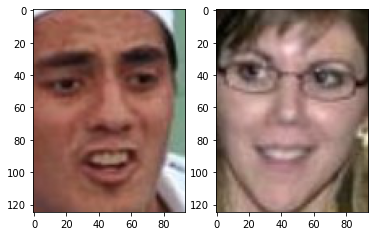

In [ ]:
index = 2109
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [7]:
lfw_people = datasets.fetch_lfw_people(
    data_home="/content/drive/MyDrive/Colab Notebooks/LFW",
    min_faces_per_person=2,
    resize=1,
    color=True,
    download_if_missing=True
)

In [ ]:
lfw_people.data.shape

(9164, 35250)

In [ ]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [ ]:
np.moveaxis(lfw_people.images, -1,-3).shape

In [ ]:
lfw_people.keys()

In [ ]:
randomstate = np.random.RandomState(seed=None)

In [ ]:
no_of_classes = len(lfw_people.target_names)

In [ ]:
pos_class = randomstate.choice(no_of_classes)
neg_class = randomstate.choice(no_of_classes)
while pos_class == neg_class:
    neg_class = randomstate.choice(classes_per_batch)
pos_class, neg_class

In [ ]:
pos_name = lfw_people.target_names[pos_class]
neg_name = lfw_people.target_names[neg_class]
pos_name, neg_name

In [ ]:
pos_imgs = lfw_people.images[lfw_people.target == pos_class]
neg_imgs = lfw_people.images[lfw_people.target == neg_class]
pos_imgs.shape[0], neg_imgs.shape[0]

In [ ]:
if pos_imgs.shape[0] == 2:
    ianc, ipos = 0,1
else:
    ianc = randomstate.randint(0, pos_imgs.shape[0])
    ipos = randomstate.randint(0, pos_imgs.shape[0])
    while ianc == ipos:
        ipos = randomstate.randint(0, len(face_classes[pos_class]))

In [ ]:
ineg = randomstate.randint(0, neg_imgs.shape[0])

In [ ]:
_,axxar = plt.subplots(1,3)
axxar[0].imshow(pos_imgs[ianc] / 255)
axxar[1].imshow(pos_imgs[ipos] / 255)
axxar[2].imshow(neg_imgs[ineg] / 255)
print(f'Pos_class : {pos_name}, Neg_class : {neg_class}')

In [8]:
def get_random_triplets(no_classes:int, images, target, no_triplets:int):
    # Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136
    randomstate = np.random.RandomState(seed=None)
    # no_class = len(lfw_people.target_names)
    triplets = []
    class_pairs = []

    ###
    # _,axxar = plt.subplots(no_triplets,3, figsize=(7,5))
    # plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    # # ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
    ###

    # progress_bar = tqdm(range(no_triplets), desc='fetching triplets')
    for progress in range(no_triplets):

        pos_class = randomstate.choice(no_classes)
        neg_class = randomstate.choice(no_classes)
        while pos_class == neg_class:
            neg_class = randomstate.choice(no_classes)

        # pos_name = lfw_people.target_names[pos_class]
        # neg_name = lfw_people.target_names[neg_class]

        pos_imgs = images[target == pos_class]
        neg_imgs = images[target == neg_class]

        if pos_imgs.shape[0] == 2:
            ianc, ipos = 0,1
        else:
            ianc = randomstate.randint(0, pos_imgs.shape[0])
            ipos = randomstate.randint(0, pos_imgs.shape[0])
            while ianc == ipos:
                ipos = randomstate.randint(0, pos_imgs.shape[0])
        ineg = randomstate.randint(0, neg_imgs.shape[0])

        ####
        # axxar[progress][0].imshow(pos_imgs[ianc] / 255)
        # axxar[progress][0].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][1].imshow(pos_imgs[ipos] / 255)
        # axxar[progress][1].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][2].imshow(neg_imgs[ineg] / 255)
        # axxar[progress][2].set_title(lfw_people.target_names[neg_class])
        ####

        triplets.append(
            torch.stack([
                torch.from_numpy(pos_imgs[ianc] / 255), 
                torch.from_numpy(pos_imgs[ipos] / 255), 
                torch.from_numpy(neg_imgs[ineg] / 255)
            ]))
        class_pairs.append((pos_class, neg_class))

    return torch.stack(triplets) , class_pairs

In [ ]:
triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names), images=lfw_people.images, target=lfw_people.target, no_triplets=500)

In [ ]:
triplets.shape

torch.Size([2200, 3, 125, 94, 3])

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

# Model

In [50]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5))),
                            ('norm', nn.BatchNorm2d(32)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(64)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(128)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=7680, out_features=2048)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=2048, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            ('relu3', nn.ReLU(inplace=True)),
        ]))

        # self.out      = nn.Linear(in_features=128, out_features=2)

        # for m in self.modules():
        #     classname = m.__class__.__name__
        #     if classname.find('Conv') != -1:
        #         nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        # x = x.view(-1, 10*6*128)
        x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        triplet = triplet.movedim(-1, -3)
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [ ]:
x = torch.rand(10, 3, 125, 94, 3)
print(x.shape)
x = x.movedim(-1, -3)
print(x.shape)
print(x[:,0,...].shape)
x = model.convnet1(x[:,0,...])
print(x.shape)
x = model.convnet2(x)
print(x.shape)
x = model.convnet3(x)
print(x.shape)
x = x.view(-1, 10*6*128)
print(x.shape)
x = model.FCs(x)
print(x.shape)
print()
x = torch.rand(10, 3, 125, 94, 3)
# x = x.movedim(-1, -3)
x = model(x)
print(x[0].shape)

torch.Size([10, 128])


In [ ]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(7, 5), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu): Re

In [10]:
class ResModel(nn.Module):
    def __init__(self):
        super(ResModel, self).__init__()

        self.resnet = torchvision.models.resnet18()
        self.linear = nn.Linear(1000, 128)

    def semi_forward(self,x):
        x = self.resnet(x)
        x = self.linear(x)
        return x

    def forward(self, triplet):
        triplet = triplet.movedim(-1, -3)
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [11]:
model = ResModel()
model

ResModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
lfw_pairs.pairs[:1100].shape

(1100, 2, 125, 94, 3)

In [ ]:
lfw_pairs.pairs[1100:, 0].shape

(1100, 125, 94, 3)

In [12]:
def triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [16]:
model = model.cuda()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfn = nn.TripletMarginLoss(margin=1, reduction='mean')

In [ ]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [21]:
cost = []

epochs = 100
for epoch in range(epochs):

    triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names),
                                                images=lfw_people.images, 
                                                target=lfw_people.target, no_triplets=100)

    apn = model(triplets.cuda())
    # apn = model(triplets)

    optimizer.zero_grad()
    loss = triplet_loss(*apn)
    # loss = lossfn(*apn)
    cost.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


Epoch:[1/100] , Cost : 0.2151099592447281
Epoch:[2/100] , Cost : 0.2952163517475128
Epoch:[3/100] , Cost : 0.32740625739097595
Epoch:[4/100] , Cost : 0.3011815845966339
Epoch:[5/100] , Cost : 0.17160381376743317
Epoch:[6/100] , Cost : 0.21059875190258026
Epoch:[7/100] , Cost : 0.19956707954406738
Epoch:[8/100] , Cost : 0.22369559109210968
Epoch:[9/100] , Cost : 0.19407770037651062
Epoch:[10/100] , Cost : 0.28157833218574524
Epoch:[11/100] , Cost : 0.22341381013393402
Epoch:[12/100] , Cost : 0.3008979260921478
Epoch:[13/100] , Cost : 0.20139482617378235
Epoch:[14/100] , Cost : 0.17312699556350708
Epoch:[15/100] , Cost : 0.26466742157936096
Epoch:[16/100] , Cost : 0.344386488199234
Epoch:[17/100] , Cost : 0.256867915391922
Epoch:[18/100] , Cost : 0.2945479154586792
Epoch:[19/100] , Cost : 0.22445757687091827
Epoch:[20/100] , Cost : 0.32060980796813965
Epoch:[21/100] , Cost : 0.23105472326278687
Epoch:[22/100] , Cost : 0.32354652881622314
Epoch:[23/100] , Cost : 0.17064040899276733
Epoch:

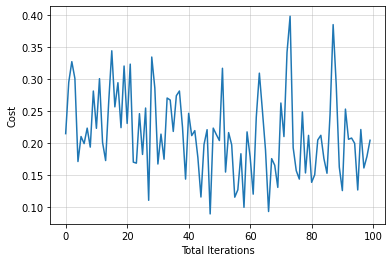

In [22]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs), cost)
plt.grid(alpha=0.5)
plt.show()

In [23]:
apn[0]

tensor([[ 0.5824,  1.4354, -0.0682,  ...,  0.6367,  0.7161,  0.3365],
        [ 0.6751,  1.6947, -0.4282,  ...,  0.5980,  0.7400,  0.5617],
        [ 0.6754,  1.8095, -0.4446,  ...,  0.5256,  0.7048,  0.5486],
        ...,
        [ 0.6993,  1.4985, -0.2161,  ...,  0.4336,  0.7048,  0.4171],
        [ 0.5520,  1.4962, -0.1790,  ...,  0.5858,  0.6826,  0.4059],
        [ 0.8510,  2.0696, -0.0508,  ...,  0.7161,  0.6761,  0.7538]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [24]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
p

tensor([0.5971, 2.0103, 2.0395, 0.6722, 1.0274, 0.8923, 1.3754, 1.3606, 1.6772,
        2.3584, 2.3244, 2.1946, 0.5201, 2.3016, 2.2402, 0.8867, 1.6952, 1.9348,
        1.5359, 1.5735, 1.8423, 1.9383, 0.6496, 3.1107, 0.6471, 0.5108, 0.7900,
        0.5731, 1.4242, 1.4321, 1.2934, 2.3479, 1.9052, 2.2851, 0.4302, 1.0491,
        1.0894, 0.4584, 1.2158, 1.2349, 3.6780, 1.9550, 1.0063, 1.4211, 0.8136,
        0.5536, 0.7128, 2.4014, 1.2612, 0.8281, 1.0814, 1.5829, 0.5618, 1.3068,
        5.0424, 1.9329, 1.0491, 0.6309, 1.3197, 0.4928, 1.3907, 1.2850, 1.9840,
        3.1862, 0.3560, 2.5708, 0.6821, 3.2893, 1.0728, 2.8762, 1.8082, 2.7887,
        1.1143, 1.4449, 0.7493, 2.3479, 1.0878, 1.6884, 1.6050, 4.7601, 0.5542,
        1.7706, 1.6509, 1.4912, 1.6196, 0.5301, 1.9752, 1.9052, 2.1107, 2.0595,
        3.3003, 1.8296, 1.6105, 0.9241, 4.0493, 2.8773, 1.4628, 2.3744, 1.6364,
        3.2402], device='cuda:0', grad_fn=<SumBackward1>)

In [25]:
n = (apn[0] - apn[2]).pow(2).sum(-1)
n

tensor([ 6.4095,  7.2364,  4.7620,  3.2898, 11.6220,  3.9447,  7.9657,  1.0790,
         9.6497,  8.7074,  3.8430,  7.7720,  1.5567,  3.5350,  6.0199,  6.5885,
         7.5782,  2.6526,  4.6531,  2.5100,  3.6129,  3.3044,  7.5005,  8.2775,
         1.3111,  7.4212,  2.5799, 11.9326,  5.9693,  5.1957,  2.3588,  7.2172,
         3.6533,  2.9059,  1.7068,  4.2555, 10.6040,  3.7603,  2.6845,  3.3586,
         2.6111,  3.5944,  6.3979,  8.8103,  3.1950,  5.3560,  3.2911,  4.9752,
         4.9405,  0.8946,  4.0434,  4.8552,  1.3601,  2.5349,  3.5688,  2.3707,
         7.5570,  2.2723,  3.6505,  1.9851,  1.1320,  2.3686,  5.3414,  5.2446,
         5.9886,  9.4403,  5.6321,  5.8873,  5.0795,  4.5479,  2.1863,  2.9475,
         1.8518,  6.3824,  2.2879,  9.0928,  2.6467,  2.3123, 13.5779,  2.3788,
         4.7114,  1.7052,  1.0438,  4.5396,  2.7395,  2.5828, 10.6039,  5.8464,
         5.2163, 10.5391,  4.2869,  1.7100,  8.8723,  1.3924,  5.8791,  4.1522,
         6.2030,  3.0146,  2.1798,  4.82

In [26]:
p.max() , p.mean() , n.max(), n.mean()

(tensor(5.0424, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(1.6414, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(13.5779, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(4.7762, device='cuda:0', grad_fn=<MeanBackward0>))

In [27]:
(p-n).mean()

tensor(-3.1348, device='cuda:0', grad_fn=<MeanBackward0>)

In [28]:
(F.relu(p-n + 1)).mean()

tensor(0.2048, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [29]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)
    

In [30]:
loader = torch.utils.data.DataLoader(lfw_pairs.pairs, batch_size=100)

In [31]:
len(loader)

22

In [32]:
sample = next(iter(loader))
sample.shape

torch.Size([100, 2, 125, 94, 3])

In [33]:
pred = []

In [39]:
for sample in loader:
    test1 = sample[:,0,...].cuda() /255
    test2 = sample[:,1,...].cuda() /255
    enc1 = model.semi_forward(test1.movedim(-1,-3))
    enc2 = model.semi_forward(test2.movedim(-1,-3))
    d = dist(enc1,enc2)
    pred.append(d.cpu().detach().numpy())

In [40]:
pre = [torch.tensor(a) for a in pred]

In [41]:
PRED = torch.cat(pre)

In [42]:
PRED.shape

torch.Size([2200])

In [45]:
PRED[:1000].mean() , PRED[1000:].mean()

(tensor(1.8809), tensor(4.1819))

In [ ]:
same_pred = PRED <= 3

In [ ]:
same_pred[:1100].sum()

tensor(715)

In [ ]:
same_pred[:1100].sum() / 1100 , "% age accuracy on Same person"

(tensor(0.6500), '% age accuracy on Same person')

In [ ]:
same_pred[1100:].sum()

tensor(199)

In [ ]:
same_pred[1100:].sum() / 1100 , "% age error on Different person"

(tensor(0.1809), '% age error on Different person')

In [48]:
index = 111
test1 = torch.from_numpy(lfw_pairs.pairs[index][0]).cuda() /255
test2 = torch.from_numpy(lfw_pairs.pairs[index][1]).cuda() /255
enc1 = model.semi_forward(test1.movedim(-1,-3).unsqueeze(0))
enc2 = model.semi_forward(test2.movedim(-1,-3).unsqueeze(0))
d = dist(enc1,enc2)
print(d)
print('Different Person') if d > 2 else print('Same Person')

tensor([0.1818], device='cuda:0', grad_fn=<SumBackward1>)
Same Person


Ben_Howland	1	2

Same person


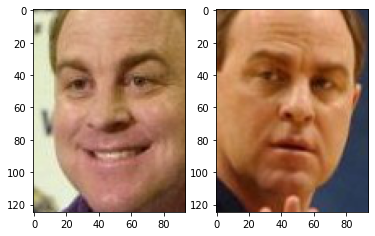

In [49]:
# Testing
# index = 3
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [ ]:
a = next(iter(LOADER))

In [ ]:
a.shape

torch.Size([10, 2, 125, 94, 3])

In [ ]:
model = model.cuda()

In [ ]:
!nvidia-smi

Tue Feb  9 13:19:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |  11348MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [ ]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese'

In [ ]:
# torch.save(model.state_dict(), PATH)

In [ ]:
# ColabCode(port=100, password='12345')

## .

In [ ]:
!pip install torchviz

     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=ec58767d618243e986be401fd4ad7f2f847e329e53c26d5a9e189caa732dbc32
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


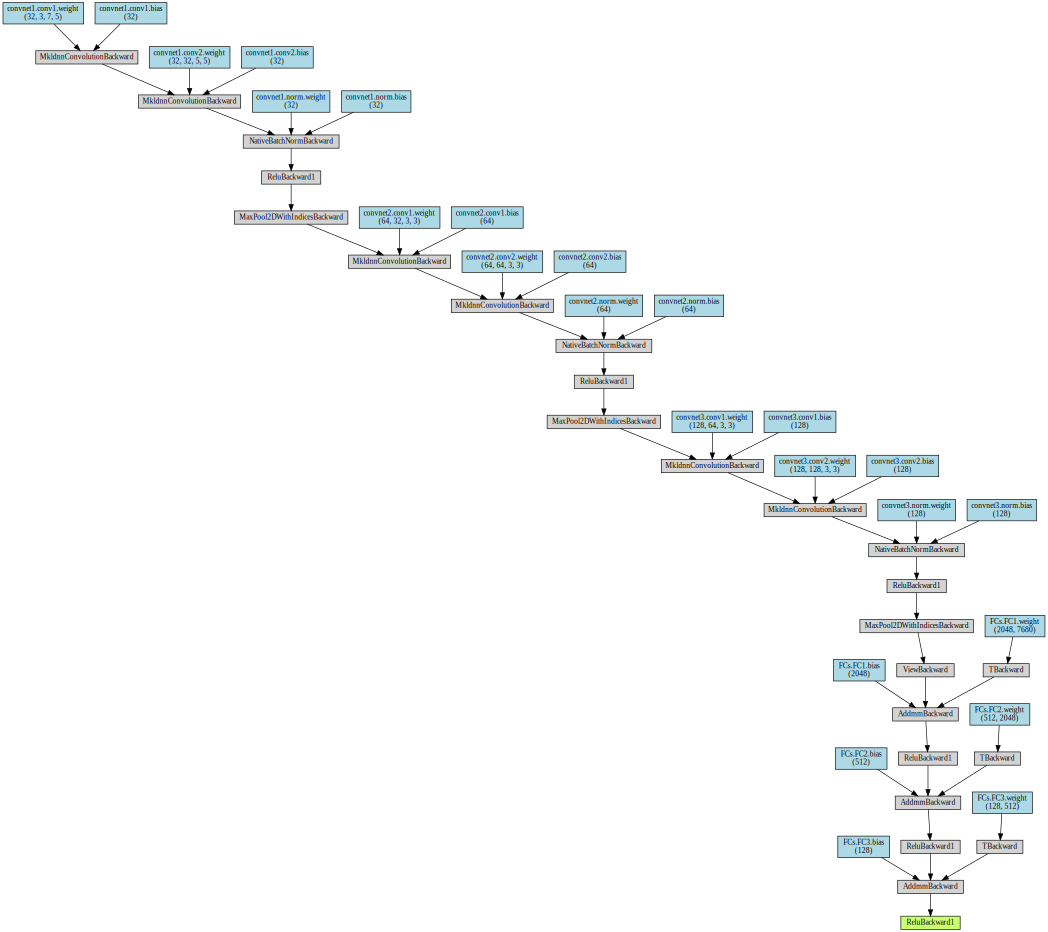

In [ ]:
from torchviz import make_dot

x = torch.randn(10,3,125,94)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-p_6ry_vw
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-p_6ry_vw
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=6e617219ef97172c7c0ebabb961e1921e232a97f2ff82f92e7c6fa61d14bb0d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mfd7y6p/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


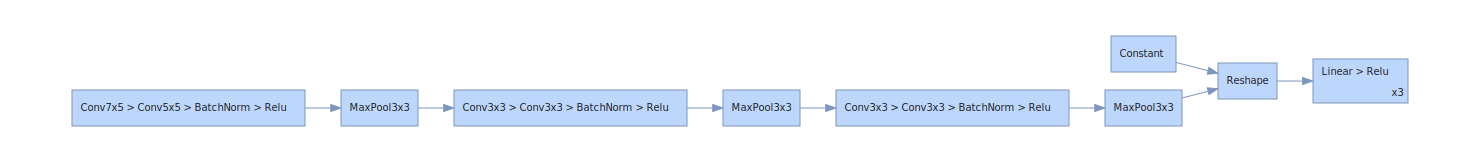

In [ ]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([10,3,125,94]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

## .

# TensorFlow

In [ ]:
import tensorflow as tf